In [ ]:
import pretty_midi
import mido
import matplotlib.pyplot as plt

In [12]:
mido_obj = mido.MidiFile("mid_files/anhao_melody.mid")
pretty_midi_obj = pretty_midi.PrettyMIDI("mid_files/anhao_melody.mid")

In [22]:
mido_obj

MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=500000, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('end_of_track', time=1)]),
  MidiTrack([
    Message('program_change', channel=0, program=0, time=0),
    Message('note_on', channel=0, note=52, velocity=77, time=15360),
    Message('note_on', channel=0, note=52, velocity=0, time=230),
    Message('note_on', channel=0, note=56, velocity=77, time=0),
    Message('note_on', channel=0, note=56, velocity=0, time=231),
    Message('note_on', channel=0, note=59, velocity=77, time=0),
    Message('note_on', channel=0, note=59, velocity=0, time=230),
    Message('note_on', channel=0, note=59, velocity=77, time=0),
    Message('note_on', channel=0, note=59, velocity=0, time=231),
    Message('note_on', channel=0, note=56, velocity=77, time=230),
    Message('note_on', channel=0, note=56, velocity=

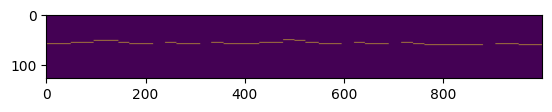

In [21]:
plt.imshow(pretty_midi_obj.get_piano_roll()[:, 11000:12000])